In [8]:
# -------------------------------
# 1. Load data CKD dari .arff
# -------------------------------
import arff
import pandas as pd

with open('chronic_kidney_disease_full.arff') as f:
    data = arff.load(f)

df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
df.head()


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1,0,None,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4,0,None,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2,3,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4,0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2,0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [9]:
# -------------------------------
# 2. Simulasi Noise (hanya di data latih nanti)
# -------------------------------
import numpy as np

# Mapping label manual dulu
label_map = {'ckd': 0, 'notckd': 1}
df['class'] = df['class'].map(label_map)

# Konversi fitur numerik
numerics = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
for col in numerics:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Simpan dulu df asli sebelum noise
df_original = df.copy()


In [10]:
# -------------------------------
# 3. Preprocessing & Split (sebelum noise)
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Imputasi numerik
for col in numerics:
    df[col] = df[col].fillna(df[col].mean())

# Encode kolom kategorikal
categoricals = list(set(df.columns) - set(numerics) - {'class'})
for col in categoricals:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = LabelEncoder().fit_transform(df[col])

# Split fitur dan label
X = df.drop('class', axis=1)
y = df['class']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# -------------------------------
# 4. Tambahkan Noise ke Data Latih
# -------------------------------
X_train_noisy = X_train.copy()

# Tambahkan noise pada fitur penting
np.random.seed(42)
for col in ['hemo', 'sc', 'bu']:
    if col in X_train_noisy.columns:
        noise = np.random.uniform(-50, 100, size=X_train_noisy.shape[0])
        X_train_noisy[col] += noise

# Normalisasi ulang
scaler = StandardScaler()
X_train_noisy = scaler.fit_transform(X_train_noisy)
X_test_scaled = scaler.transform(X_test)


In [12]:
# -------------------------------
# 5. Training dan Evaluasi
# -------------------------------
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Linear
model_linear = SVC(kernel='linear', C=1.0)
model_linear.fit(X_train_noisy, y_train)
y_pred_linear = model_linear.predict(X_test_scaled)
print("📊 Classification Report (SVM Linear):")
print(classification_report(y_test, y_pred_linear, target_names=['ckd', 'notckd']))
print("🧮 Confusion Matrix (SVM Linear):")
print(confusion_matrix(y_test, y_pred_linear))
print(f"✅ Akurasi SVM Linear: {accuracy_score(y_test, y_pred_linear)*100:.2f}%")

# RBF
model_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
model_rbf.fit(X_train_noisy, y_train)
y_pred_rbf = model_rbf.predict(X_test_scaled)
print("\n📊 Classification Report (SVM RBF):")
print(classification_report(y_test, y_pred_rbf, target_names=['ckd', 'notckd']))
print("🧮 Confusion Matrix (SVM RBF):")
print(confusion_matrix(y_test, y_pred_rbf))
print(f"🔹 Akurasi SVM RBF: {accuracy_score(y_test, y_pred_rbf)*100:.2f}%")


📊 Classification Report (SVM Linear):
              precision    recall  f1-score   support

         ckd       1.00      0.98      0.99        52
      notckd       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

🧮 Confusion Matrix (SVM Linear):
[[51  1]
 [ 0 28]]
✅ Akurasi SVM Linear: 98.75%

📊 Classification Report (SVM RBF):
              precision    recall  f1-score   support

         ckd       1.00      0.98      0.99        52
      notckd       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

🧮 Confusion Matrix (SVM RBF):
[[51  1]
 [ 0 28]]
🔹 Akurasi SVM RBF: 98.75%


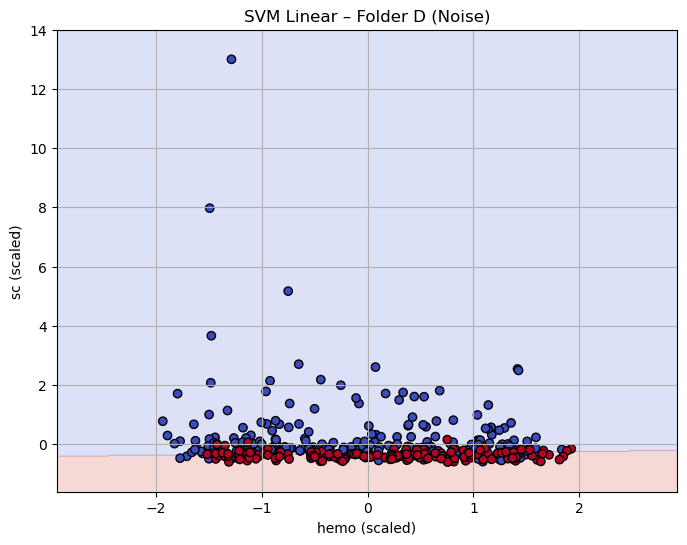

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import arff

# Load & preprocessing awal
with open('chronic_kidney_disease_full.arff') as f:
    data = arff.load(f)
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
df_viz = df[['hemo', 'sc', 'class']].copy()
df_viz['hemo'] = pd.to_numeric(df_viz['hemo'], errors='coerce').fillna(df_viz['hemo'].mean())
df_viz['sc'] = pd.to_numeric(df_viz['sc'], errors='coerce').fillna(df_viz['sc'].mean())
df_viz['class'] = df_viz['class'].map({'ckd': 0, 'notckd': 1})

# Tambahkan noise
np.random.seed(42)
df_viz['hemo'] += np.random.uniform(-30, 30, size=df_viz.shape[0])
df_viz['sc'] += np.random.uniform(-1, 1, size=df_viz.shape[0])

# Normalisasi dan training
X = df_viz[['hemo', 'sc']].values
y = df_viz['class'].values
X_scaled = StandardScaler().fit_transform(X)
model = SVC(kernel='linear').fit(X_scaled, y)

# Plot
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("SVM Linear – Folder D (Noise)")
plt.xlabel("hemo (scaled)")
plt.ylabel("sc (scaled)")
plt.grid(True)
plt.show()


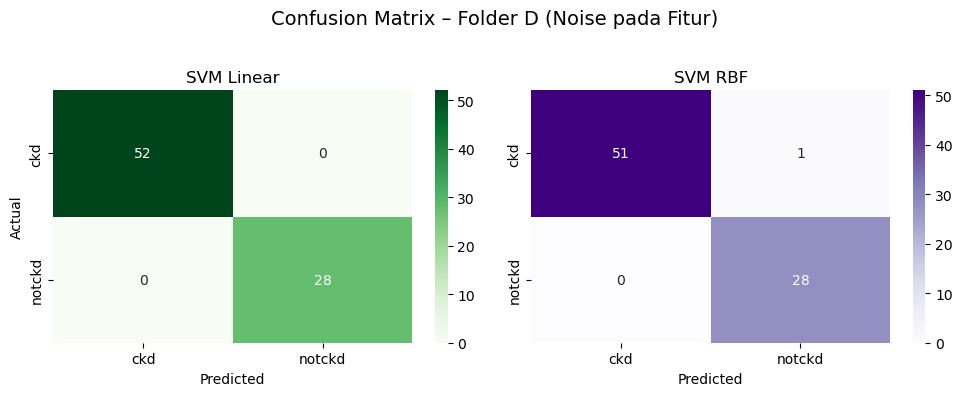

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix untuk Linear dan RBF
cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

# Buat figure berdampingan
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# SVM Linear
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Greens',
            xticklabels=['ckd', 'notckd'], yticklabels=['ckd', 'notckd'],
            ax=axes[0])
axes[0].set_title("SVM Linear")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# SVM RBF
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['ckd', 'notckd'], yticklabels=['ckd', 'notckd'],
            ax=axes[1])
axes[1].set_title("SVM RBF")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

# Tata letak rapi
plt.suptitle("Confusion Matrix – Folder D (Noise pada Fitur)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
